In [2]:
import sys
 
sys.path.insert(0, "../")

In [2]:
from dataAnalysis.DataAnalysis import DataAnalysis
import pandas as pd

data = pd.read_csv(r"./sbcdata.csv", header=0)
data_analysis = DataAnalysis(data, mimic_data = None)

/home/dwalke/git/graph_aware_ml/dataAnalysis/data/Filter.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Label'] = self.data['Diagnosis']
/home/dwalke/git/graph_aware_ml/dataAnalysis/data/Filter.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Label'] = self.data['Diagnosis']
/home/dwalke/git/graph_aware_ml/dataAnalysis/data/Filter.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [3]:
data = pd.concat((data_analysis.get_training_data(), data_analysis.get_testing_data()))
max_Id = data["Id"].unique().max()
gw_data = data_analysis.get_gw_testing_data().copy(deep=True)
gw_data = gw_data.assign(Id=lambda x: x.Id + max_Id)
data = pd.concat((data, gw_data))
data = data.sort_values(["Id", "Time"])
data = data.reset_index(drop=True)
popped_index = data.pop("index")

In [4]:
from dataAnalysis.Constants import SEX_CATEGORY_COLUMN_NAME, SEX_COLUMN_NAME, FEATURES
data[SEX_CATEGORY_COLUMN_NAME] = data.loc[:, SEX_COLUMN_NAME] =="W"

data[SEX_CATEGORY_COLUMN_NAME] = data[SEX_CATEGORY_COLUMN_NAME].astype("int8")
data["Label"] = data["Label"] == "Sepsis"
data["Label"] = data["Label"].astype("int8")

## Edge index construction

In [7]:
import numpy as np
from tqdm.notebook import tqdm

def get_edge_index(dataset):
    dataset = dataset.reset_index(drop=True)
    source_edge_index = []
    target_edge_index = []

    for Id, group in dataset.groupby("Id"):
        indices = group.index
        offset = indices[0]
        num_nodes = len(indices)
        edge_index = torch.zeros((2, sum(range(num_nodes + 1))), dtype=torch.long)+offset

        ## Self edges
        edge_index[:, 0:num_nodes] = (torch.arange(num_nodes) + offset).view(1, -1)
        idx = num_nodes
        for i in range(1, num_nodes):
            edge_index[1, idx:idx + i] = i+offset
            edge_index[0, idx:idx + i] = torch.arange(i)+offset
            idx += i

        source_edge_index.extend(edge_index[0, :].numpy().tolist())
        target_edge_index.extend(edge_index[1, :].numpy().tolist())

    edge_index = np.asarray([np.asarray(source_edge_index), np.asarray(target_edge_index)])
    edge_index = torch.tensor(edge_index)
    return edge_index

In [8]:
test_edge_index = get_edge_index(data[(data["Set"] == "Validation") & (data["Center"] == "Leipzig")])
test_gw_edge_index = get_edge_index(data[(data["Set"] == "Validation") & (data["Center"] == "Greifswald")])
train_edge_index = get_edge_index(data[data["Set"] == "Training"])

## Framework

In [10]:
import torch

class Framework:
    #edge_index ##torch_tensor
    #features ##numpy array or torch tensor with shape mxn
    #user_function ## user-defined function
    #concat: Optional[bool] ## whether concatanate or add
    #handle_nan replace nan values with given number e.g., when dividing in user-defined function by zero
    ## normaliz- if false pseudo-attention scores might contain -inf or inf
        
    def __init__(self, features, edge_index, user_function,handle_nan:float=None,
                 concat = True, gpu_idx:int=None, normalize:bool=True, use_pseudo_attention = True):
        self.features = features
        self.edge_index = edge_index
        self.user_function = user_function
        self.concat = concat
        self.handle_nan = handle_nan
        self.normalize = normalize
        self.use_pseudo_attention = use_pseudo_attention
        
        self.device = torch.device(f"cuda:{str(gpu_idx)}") if gpu_idx is not None and torch.cuda.is_available() else torch.device("cpu")
        
        self.make_tensors()
        if gpu_idx is not None: self.shift_device()
        
    def make_tensors(self):
        if not torch.is_tensor(self.features):
            try:
                self.features = torch.from_numpy(self.features)
            except:
                raise Exception("Features input must be numpy array or torch tensor")
        if not torch.is_tensor(self.edge_index):
            try:
                self.edge_index = torch.from_numpy(self.edge_index)
            except:
                raise Exception("Edge index must be numpy array or torch tensor")
        if self.edge_index.shape[0] != 2:
            raise Exception("Edge index must have the shape 2 x NumberOfEdges")
        #check max edge index and shape of features
    
    def shift_device(self):
        self.features = self.features.to(self.device) 
        self.edge_index = self.edge_index.to(self.device) 
    
    def aggregate(self, hops = 1):
        if hops <= 0:
            raise Exception("Number of hops must be greater or equal to 1.")
            
        features_for_aggregation = self.features
        for i in range(hops):
            if self.normalize:
                features_for_aggregation = torch.nn.functional.normalize(features_for_aggregation, dim = 0)
            source_lift = features_for_aggregation.index_select(0, self.edge_index[0])
            target = self.edge_index[1]
            
            if self.use_pseudo_attention:
                cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
                score = cos(source_lift, features_for_aggregation.index_select(0, target))
                exp_score = torch.exp(score)
                summed_exp_score = torch.zeros_like(exp_score).scatter(0, target,exp_score, reduce="add")
                target_lifted_summed_exp_score = summed_exp_score.index_select(0, self.edge_index[1])
                normalized_scores = exp_score / target_lifted_summed_exp_score
                source_lift = normalized_scores.unsqueeze(1) * source_lift
            
            summed_neighbors = torch.zeros_like(features_for_aggregation, device=self.device).scatter(0, target.unsqueeze(0).repeat(features_for_aggregation.shape[1], 1).t(), source_lift, reduce="add")
            multiplied_neighbors = torch.ones_like(features_for_aggregation, device=self.device).scatter(0, target.unsqueeze(0).repeat(features_for_aggregation.shape[1], 1).t(), source_lift, reduce="multiply")

            num_source_neighbors = torch.zeros(features_for_aggregation.shape[0], dtype=torch.float, device=self.device)
            num_source_neighbors.scatter_(0, target, torch.ones_like(target, dtype=torch.float, device=self.device), reduce="add")
            num_source_neighbors = num_source_neighbors.unsqueeze(-1)

            out = self.user_function(self.features,features_for_aggregation,
                                     summed_neighbors, multiplied_neighbors, num_source_neighbors)
            
            if self.handle_nan is not None:
                out = torch.nan_to_num(out, nan=self.handle_nan)
            features_for_aggregation = out
        new_features = torch.concat((self.features, features_for_aggregation), dim = 1) if self.concat else torch.add(self.features, features_for_aggregation)
        return new_features
            
        
    

In [191]:
import numpy
def user_function(origin_features, updated_features, sum_neighbors, mul_neighbors, num_neighbors):
    return sum_neighbors / num_neighbors##is this incorporating all neigbors? ##TODO check

In [192]:
## small test case
edge_index = torch.tensor([[0,1,2,3], [0,0,0, 2]], dtype=torch.long)
X_f = torch.tensor([[0,1,2], [2,4,8],[4,8,16], [8,16,32]], dtype=torch.float)
test_framework = Framework(X_f, edge_index, user_function,handle_nan=0,concat =True, gpu_idx=0)
X_new_f = test_framework.aggregate(1).cpu().numpy()
X_new_f

array([[0.        , 0.05447347, 0.05447347, 0.06815251, 0.07486726,
        0.07486726],
       [0.21821788, 0.21789388, 0.21789388, 0.        , 0.        ,
        0.        ],
       [0.43643576, 0.43578777, 0.43578777, 0.8728715 , 0.87157553,
        0.87157553],
       [0.8728715 , 0.87157553, 0.87157553, 0.        , 0.        ,
        0.        ]], dtype=float32)

In [193]:
cos = torch.nn.CosineSimilarity(dim=0, eps=1e-6)
a = torch.tensor([1,0]).type(torch.float)
b = torch.tensor([0,-1]).type(torch.float)
torch.sigmoid(cos(a,b))

tensor(0.5000)

In [233]:
import numpy
def user_function(origin_features, updated_features, sum_neighbors, mul_neighbors, num_neighbors):
    return origin_features - sum_neighbors / num_neighbors

In [234]:
from dataAnalysis.Constants import FEATURES, LABEL_COLUMN_NAME

train_mask = data["Set"] == "Training"
X_train = data.loc[train_mask, FEATURES].values
y_train = data.loc[train_mask, LABEL_COLUMN_NAME].values

test_mask = (data["Set"] == "Validation") & (data["Center"] == "Leipzig")
X_test = data.loc[test_mask, FEATURES].values
y_test = data.loc[test_mask, LABEL_COLUMN_NAME].values

test_gw_mask = (data["Set"] == "Validation") & (data["Center"] == "Greifswald")
X_test_gw = data.loc[test_gw_mask, FEATURES].values
y_test_gw = data.loc[test_gw_mask, LABEL_COLUMN_NAME].values

In [235]:
def reverse_edge_index(edge_index):
    rev_edge_index = torch.zeros_like(edge_index)
    index = torch.LongTensor([1,0])
    rev_edge_index[index] = edge_index
    return rev_edge_index

In [236]:
rev_train_edge_index = reverse_edge_index(train_edge_index)
rev_test_edge_index = reverse_edge_index(test_edge_index)
rev_test_gw_edge_index = reverse_edge_index(test_gw_edge_index)

In [237]:
from torch_geometric.utils import to_undirected
undir_train_edge_index = to_undirected(train_edge_index)
undir_test_edge_index = to_undirected(test_edge_index)
undir_test_gw_edge_index = to_undirected(test_gw_edge_index)

In [238]:
framework_train = Framework(X_train, train_edge_index, user_function,handle_nan=0,concat =True, gpu_idx=0, normalize=False, use_pseudo_attention=False)
framework_test = Framework(X_test, test_edge_index, user_function,handle_nan=0,concat =True, gpu_idx=0, normalize=False, use_pseudo_attention=False)
framework_test_gw = Framework(X_test_gw, test_gw_edge_index, user_function,handle_nan=0,concat =True, gpu_idx=0, normalize=False, use_pseudo_attention=False)

In [243]:
X_train_new = framework_train.aggregate(hops=1).cpu().numpy()
X_test_new = framework_test.aggregate(hops=1).cpu().numpy()
X_test_gw_new = framework_test_gw.aggregate(hops=1).cpu().numpy()

In [244]:
X_train_new.shape

(1015074, 14)

## Random forest

In [245]:
from dataAnalysis.Metrics import Evaluation

evaluation = Evaluation(y_test, y_test_gw, X_test_new, X_test_gw_new)

37.335859298706055
         Name       MCC  F1-Micro  F1-Macro  F1-Binary     AUROC     AUPRC
0     Leipzig  0.072555  0.914624  0.487527   0.019687  0.888229  0.021957
1  Greifswald  0.049143  0.908840  0.482022   0.011828  0.839776  0.010216
[0.09870155 0.01276628 0.05795552 0.43072064 0.06678433 0.03593689
 0.11810287 0.00049834 0.         0.02768585 0.05989453 0.03543662
 0.02359248 0.03192411]


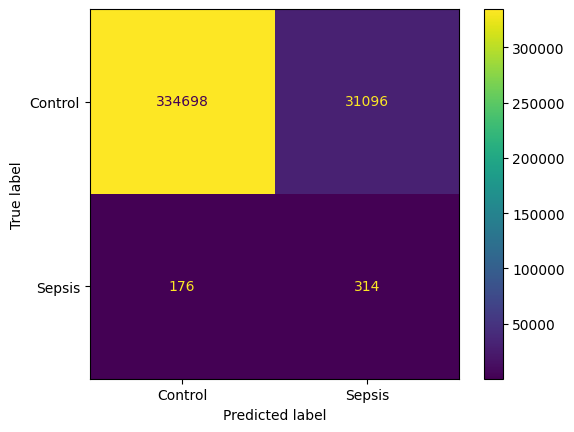

In [246]:
from sklearn.ensemble import RandomForestClassifier
import time
start = time.time()
random_forest = RandomForestClassifier(class_weight={0: 0.0025, 1: 1}, max_leaf_nodes=79,
                           min_samples_leaf=0.0001,
                           min_samples_split=0.0055,
                           n_estimators=500, random_state=42, n_jobs=-1)
random_forest.fit(X_train_new, y_train)
print(time.time() -start)
print(evaluation.get_df_metrics(random_forest))
evaluation.plot_confusion_matrix(random_forest)
print(random_forest.feature_importances_)

In [55]:
undir_train_edge_index.shape[1] + undir_test_edge_index.shape[1] + undir_test_gw_edge_index.shape[1]

12698987

## Cora experiments

In [4]:
##this will lead to problems -> lets see if i can fix them e.g. with dimension reduction techniques or some other ideas
from torch_geometric.datasets import Planetoid
dataset = Planetoid(root='/tmp/Cora', name='Cora', num_val=0)

In [5]:
dataset[0].x.shape

torch.Size([2708, 1433])

In [6]:
X = dataset[0].x
y = dataset[0].y

test = dataset[0].test_mask
# val = dataset[0].val_mask
train = ~test#dataset[0].train_mask

y_train = y[train]
# y_val = y[val]
y_test = y[test]

In [8]:
import numpy
def user_function(origin_features, updated_features, sum_neighbors, mul_neighbors, num_neighbors):
    return updated_features + sum_neighbors/num_neighbors ##is this incorporating all neigbors? ##TODO check

In [11]:
cora_framework = Framework(X, dataset[0].edge_index, user_function,handle_nan=0,concat =True, gpu_idx=0, normalize=True, use_pseudo_attention=True)
X_new = cora_framework.aggregate(2).cpu().numpy()

/tmp/ipykernel_132448/1197765397.py:60: UserWarning: The reduce argument of torch.scatter with Tensor src is deprecated and will be removed in a future PyTorch release. Use torch.scatter_reduce instead for more reduction options. (Triggered internally at ../aten/src/ATen/native/TensorAdvancedIndexing.cpp:224.)
  summed_exp_score = torch.zeros_like(exp_score).scatter(0, target,exp_score, reduce="add")


In [12]:
X_train = X_new[train]
# X_val = X_new[val]
X_test = X_new[test]

In [13]:
X_train.shape

(1708, 2866)

In [17]:
X_train[:, :(X_train.shape[1] // 2)].shape

(1708, 1433)

In [18]:
from xgboost import XGBClassifier
bst = XGBClassifier( tree_method='gpu_hist', 
                           n_estimators=1000,
                           max_depth=2,
                           eta=0.1,
                           min_child_weight = 7,
                           max_delta_step= 7,
                           sampling_method= "uniform")
bst.fit(X_train[:, :(X_train.shape[1] // 2) ], y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=7, max_depth=2,
              max_leaves=None, min_child_weight=7, missing=nan,
              monotone_constraints=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [19]:
from xgboost import XGBClassifier
bst_nh = XGBClassifier( tree_method='gpu_hist', 
                           n_estimators=1000,
                           max_depth=2,
                           eta=0.1,
                           min_child_weight = 7,
                           max_delta_step= 7,
                           sampling_method= "uniform")
bst_nh.fit(X_train[:, (X_train.shape[1] // 2): ], y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=7, max_depth=2,
              max_leaves=None, min_child_weight=7, missing=nan,
              monotone_constraints=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [20]:
import numpy as np
pred = bst.predict(X_test[:, :(X_test.shape[1] // 2)])
#     print(np.equal(pred_val, y_val).sum() / y_val.shape[0])
print(np.equal(pred, y_test).sum() / y_test.shape[0])

tensor(0.7190)


In [21]:
import numpy as np
pred_nh = bst_nh.predict(X_test[:, (X_test.shape[1] // 2):])
#     print(np.equal(pred_val, y_val).sum() / y_val.shape[0])
print(np.equal(pred_nh, y_test).sum() / y_test.shape[0])

tensor(0.8700)


In [34]:
pred_comb = ((bst_nh.predict_proba(X_test[:, (X_test.shape[1] // 2):]) + bst.predict_proba(X_test[:, :(X_test.shape[1] // 2)]))).argmax(1)
print(np.equal(pred_comb, y_test).sum() / y_test.shape[0])

tensor(0.8860)


In [303]:
X_train.shape

(1708, 2866)

In [304]:
X_test.shape

(1000, 2866)

In [305]:
from sklearn.ensemble import RandomForestClassifier
import time
start = time.time()
random_forest = RandomForestClassifier(n_jobs=-1, random_state=42, class_weight='balanced', n_estimators=600, max_leaf_nodes=50,
                                      min_samples_leaf=.02)
random_forest.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_leaf_nodes=50,
                       min_samples_leaf=0.02, n_estimators=600, n_jobs=-1,
                       random_state=42)

In [331]:
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_class_weight

# calculate class weights based on the training data
# class_weights = compute_class_weight('balanced', classes=[0, 1], y=y_train)

bst = XGBClassifier( tree_method='gpu_hist', 
                           n_estimators=1000,
                           max_depth=2,
                           eta=0.1,
                           min_child_weight = 7,
                           max_delta_step= 7,
                           sampling_method= "uniform")
bst.fit(X_train, y_train)

[08:10:40] WARNING: ../src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=7, max_depth=2,
              max_leaves=None, min_child_weight=7, missing=nan,
              monotone_constraints=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [318]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6])

In [325]:
weights = []
for label in np.unique(y_train):
    weight = (y_train == label).sum() / y_train.shape[0]
    weights.append(weight.item())
weights

[0.12939110398292542,
 0.07377049326896667,
 0.16042155027389526,
 0.29215458035469055,
 0.16217797994613647,
 0.11416862159967422,
 0.06791569292545319]

In [337]:
np.equal(y_test, bst.predict(X_test)).sum()

tensor(872)

In [338]:
y_test.shape[0]

1000

In [332]:
def validate():
#     pred_val = random_forest.predict(X_val)
    pred = bst.predict(X_test)
#     print(np.equal(pred_val, y_val).sum() / y_val.shape[0])
    print(np.equal(pred, y_test).sum() / y_test.shape[0])
validate() 

tensor(0.8720)


In [213]:
## TODO:Test other algorithm (decision tree + XGBoost)

## Notes

(Framework wird extrem kritisch hinterfragt wegen des curse of dimensionality)

- Results of SBC similar to "Edges are all you need" without normalize and without pseudo-attention
- Iterative aggregation through hops similar to GNN layer
- Graph-awareness in ML Algorithms: with zero hops or just hop the acc drops a lot
- Extremely fast computation wiith node lifting and torch scatter which can utilize a GPU
- Even without SparsePCA high acc although number of features is now higher than number of nodes -> important for Ronalds Dataset (would still recommend implement dimensionality reduction in framework - before or after? aggregation part) -> potential reason: sparsity of cora features
- solely "feature engineering/manipulation" (I do not change algorithmic details) -> fully compatible with scikit learn, xgboost, Rahuls DTP plugin

In [342]:
from sklearn.model_selection import GridSearchCV

def get_best_estimator(model, param_grid):
    grid = GridSearchCV(
    n_jobs=-1,
    cv=10,
    estimator=model,
    scoring=['accuracy'],
    refit="accuracy",
    return_train_score=True,
    param_grid=param_grid,
    verbose= 10
    )
    grid.fit(X_train, y_train)
    return grid.best_estimator_
    

In [ ]:
from sklearn.ensemble import RandomForestClassifier
param_grid={
    'n_estimators': range(500, 1500, 100),
    'max_depth':range(1,10, 1),#0 to 10
    'eta':np.linspace(0.1, 1, 5),
    'min_child_weight': range(1, 20, 1),
                           
    }
xgb = get_best_estimator(XGBClassifier(random_state=42, tree_method='gpu_hist',sampling_method= "uniform",device="cuda"),
                                   param_grid)

Fitting 10 folds for each of 8550 candidates, totalling 85500 fits


In [ ]:
from sklearn.ensemble import RandomForestClassifier
param_grid={
        'n_estimators': range(200, 800, 100),
         'max_leaf_nodes': range(10, 60, 10),
        'min_samples_leaf': np.linspace(0.02, 0.3, 2, endpoint=True),
    'class_weight':{"balanced"}
    }
random_forest = get_best_estimator(RandomForestClassifier(random_state=42), param_grid)

In [146]:
random_forest

RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=0.020000000000000004,
                       n_estimators=600, random_state=42)

In [319]:
np.unique(y_train.numpy(), return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6]), array([221, 126, 274, 499, 277, 195, 116]))

In [202]:
y_test.shape[0]

1000

In [39]:
edge_index = torch.tensor([[0,1,2, 0],
                          [0,0,0, 2]], dtype=torch.long)

In [40]:
features = torch.tensor([[1,2,3], [2,4,6], [4,8,12], [8, 16, 24]], dtype=torch.float)

In [41]:
framework = Framework(features, edge_index, user_function,handle_nan=0,concat =True, gpu_idx=0)

In [42]:
framework.aggregate(1)

tensor([[ 1.,  2.,  3.],
        [ 2.,  4.,  6.],
        [ 4.,  8., 12.],
        [ 8., 16., 24.]], device='cuda:0')


tensor([[ 1.0000,  2.0000,  3.0000, -1.3333, -2.6667, -4.0000],
        [ 2.0000,  4.0000,  6.0000,  0.0000,  0.0000,  0.0000],
        [ 4.0000,  8.0000, 12.0000,  3.0000,  6.0000,  9.0000],
        [ 8.0000, 16.0000, 24.0000,  0.0000,  0.0000,  0.0000]],
       device='cuda:0')

In [45]:
framework.aggregate(4)

tensor([[ 1.,  2.,  3.],
        [ 2.,  4.,  6.],
        [ 4.,  8., 12.],
        [ 8., 16., 24.]], device='cuda:0')
tensor([[-1.3333, -2.6667, -4.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 3.0000,  6.0000,  9.0000],
        [ 0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-1.8889, -3.7778, -5.6667],
        [ 0.0000,  0.0000,  0.0000],
        [ 4.3333,  8.6667, 13.0000],
        [ 0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-2.7037, -5.4074, -8.1111],
        [ 0.0000,  0.0000,  0.0000],
        [ 6.2222, 12.4444, 18.6667],
        [ 0.0000,  0.0000,  0.0000]], device='cuda:0')


tensor([[  1.0000,   2.0000,   3.0000,  -3.8765,  -7.7531, -11.6296],
        [  2.0000,   4.0000,   6.0000,   0.0000,   0.0000,   0.0000],
        [  4.0000,   8.0000,  12.0000,   8.9259,  17.8519,  26.7778],
        [  8.0000,  16.0000,  24.0000,   0.0000,   0.0000,   0.0000]],
       device='cuda:0')

In [249]:
import time
for i in range(10000):
    print("Sleep")
    time.sleep(60)

Sleep
Sleep
Sleep


KeyboardInterrupt: 